In [1]:
# Mount to Google Drive & Switch to the dataset directory
import os

os.chdir("D:\Work\Machine Learning\ml-competition-sp25")
os.listdir()
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import torch
import random
import numpy as np

# Set a fixed random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, npz_path):
        npz_data = np.load(npz_path)
        self.images = npz_data["images"] # (N, 3, 128, 128) in np.uint8
        self.labels = npz_data["labels"] # (N,) in np.int64
        assert self.images.shape[0] == self.labels.shape[0]
        print(f"{npz_path}: images shape {self.images.shape}, "
              f"labels shape {self.labels.shape}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]) / 255 # convert to [0, 1] range
        label = torch.tensor(self.labels[idx])
        return image, label

train_dataset = CustomDataset("train.npz")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

train.npz: images shape (18900, 3, 128, 128), labels shape (18900,)


In [5]:
# sample data batch
train_iter = iter(train_loader)
images, labels = next(train_iter)
print(f"images shape: {images.shape}")
print(f"labels shape: {labels.shape}")

images shape: torch.Size([128, 3, 128, 128])
labels shape: torch.Size([128])


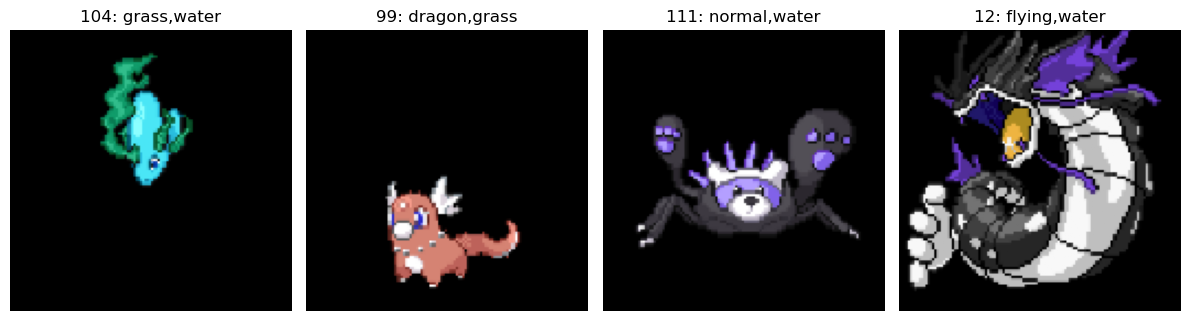

In [6]:
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')
# load label text
with open('label2type.txt', 'r') as f:
    label2type = eval(f.read())

# plot samples
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axes):
    label = labels[i].item()
    # (C, H, W) to (H, W, C) for plotting
    ax.imshow(images[i].numpy().transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f"{label}: {label2type[label]}")
plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, input_channels=3, latent_channels=128):
        super().__init__()

        # --- Encoder ---
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=2, padding=1),  # 128 x 64 x 64
            nn.GroupNorm(16, 128),
            nn.LeakyReLU(0.2)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),             # 256 x 32 x 32
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),            # 512 x 16 x 16
            nn.GroupNorm(64, 512),
            nn.LeakyReLU(0.2)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(512, latent_channels, kernel_size=3, stride=2, padding=1), # latent_channels x 8 x 8
            nn.GroupNorm(16, latent_channels),
            nn.Tanh()
        )

        # --- Decoder ---
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # 512 x 16 x 16
            nn.GroupNorm(64, 512),
            nn.LeakyReLU(0.2)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256 x 32 x 32
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),    # 128 x 64 x 64
            nn.GroupNorm(16, 128),
            nn.LeakyReLU(0.2)
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(128, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 3 x 128 x 128
            nn.Tanh()
        )

    def preprocess(self, x):
        # Adjusted to scale input to [-1, 1] and center around 0
        return (x - 0.5) * 2

    def encode(self, x):
        x = self.preprocess(x)
        z1 = self.encoder1(x)
        z2 = self.encoder2(z1)
        z3 = self.encoder3(z2)
        z = self.encoder4(z3)
        return z

    def decode(self, z):
        z = self.decoder1(z)
        z = self.decoder2(z)
        z = self.decoder3(z)
        x_recon = self.decoder4(z)
        return (x_recon + 1) / 2  # Rescale to [0, 1]

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----- Loss Function -----
def vae_loss(x, x_recon, kl_weight=0.1):
    recon_loss = F.mse_loss(x, x_recon, reduction='mean')
    kl_loss = torch.tensor(0.0)  # No KL loss in this version
    final_loss = recon_loss + kl_weight * kl_loss
    return final_loss, recon_loss, kl_loss

# ----- Training -----
def train_vae(model, dataloader, optimizer, device, num_epochs=1, start_epoch=1):
    model.train()
    for epoch in range(start_epoch, start_epoch + num_epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch}/{start_epoch + num_epochs - 1}")
        for images, labels in loop:
            images = images.to(device)
            optimizer.zero_grad()
            x_recon, z = model(images)
            loss, recon_loss, kl_loss = vae_loss(images, x_recon)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item(), recon=recon_loss.item())

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
train_vae(model, train_loader, optimizer, device, num_epochs=10)

Epoch 10/10: 100%|██████████| 148/148 [00:28<00:00,  5.23it/s, loss=0.00383, recon=0.00383]


In [9]:
import torch
import torch.optim as optim

# Load checkpoint
checkpoint = torch.load("checkpoint.pt")
print(checkpoint.keys())  # Verify checkpoint content

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = ConvVAE().to(device)
model.load_state_dict(checkpoint)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Since we don't have epoch information, set start_epoch to 1
start_epoch = 1

# Resume training
train_vae(model, train_loader, optimizer, device, num_epochs=25, start_epoch=start_epoch)

odict_keys(['encoder1.0.weight', 'encoder1.0.bias', 'encoder1.1.weight', 'encoder1.1.bias', 'encoder2.0.weight', 'encoder2.0.bias', 'encoder2.1.weight', 'encoder2.1.bias', 'encoder3.0.weight', 'encoder3.0.bias', 'encoder3.1.weight', 'encoder3.1.bias', 'encoder4.0.weight', 'encoder4.0.bias', 'encoder4.1.weight', 'encoder4.1.bias', 'decoder1.0.weight', 'decoder1.0.bias', 'decoder1.1.weight', 'decoder1.1.bias', 'decoder2.0.weight', 'decoder2.0.bias', 'decoder2.1.weight', 'decoder2.1.bias', 'decoder3.0.weight', 'decoder3.0.bias', 'decoder3.1.weight', 'decoder3.1.bias', 'decoder4.0.weight', 'decoder4.0.bias'])


Epoch 2/25:  42%|████▏     | 62/148 [00:12<00:16,  5.14it/s, loss=0.000448, recon=0.000448]


KeyboardInterrupt: 

Latent bottleneck dimension: 8192


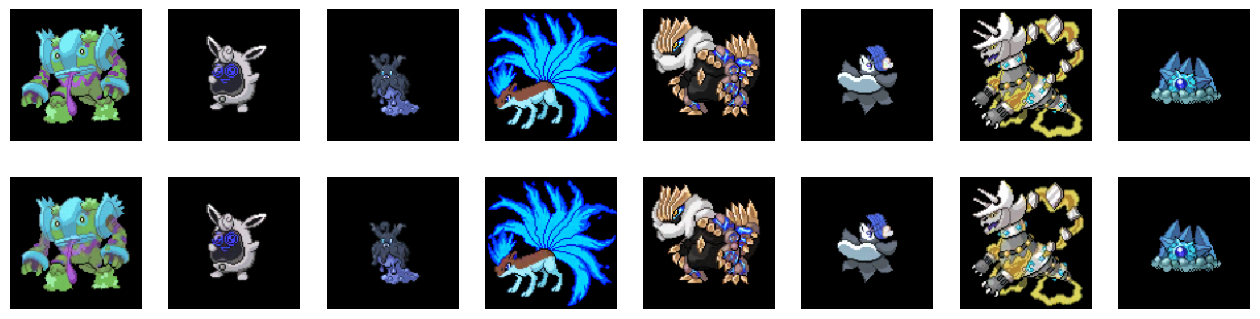

In [13]:
# ----- Visualization -----
def plot_reconstructions(model, dataloader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        x = next(iter(dataloader))[0].to(device)
        x_recon, z = model(x)
        x = x.cpu().numpy()
        x_recon = x_recon.cpu().numpy()
        print(f"Latent bottleneck dimension: {z.flatten(start_dim=1).shape[1]}")

        plt.figure(figsize=(16, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i+1)
            plt.imshow(x[i].transpose(1, 2, 0))  # (C, H, W) -> (H, W, C)
            plt.axis('off')

            # Reconstruction
            plt.subplot(2, num_images, i+1+num_images)
            plt.imshow(x_recon[i].transpose(1, 2, 0))
            plt.axis('off')

        plt.show()

# Visualize
plot_reconstructions(model, train_loader, device, num_images=8)

In [14]:
# Submission

# 1) Save model weights
torch.save(model.state_dict(), "checkpoint3.pt")

# 2) Prepare the 'Model' class for submission
with open("model.py", "r") as f:
    print(f.read())

# 3) Submit the model code & weights online

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_channels=3, latent_channels=128):
        super().__init__()

        # --- Encoder ---
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=2, padding=1),  # 128 x 64 x 64
            nn.GroupNorm(16, 128),
            nn.LeakyReLU(0.2)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),             # 256 x 32 x 32
            nn.GroupNorm(32, 256),
            nn.LeakyReLU(0.2)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),            # 512 x 16 x 16
            nn.GroupNorm(64, 512),
            nn.LeakyReLU(0.2)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(512, latent_channels, kernel_size=3, stride=2, padding=1), # latent_channels x 8 x 8
            n

In [ ]:
# Metric 1: Recon MSE on test set (on value range [0, 1])
# Metric 2: Classification accuracy (linear probing with test set latents, 170 classes)
# Final Score: recon_mse / probing_accuracy (the lower the better)